# Machine Learning HW5 - Hesam Korki

We need to first set the right environment for testing different approaches to the armed bandit problems


The general problem goal is to get an estimate of Qt(a):

   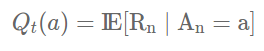
   
   
## Gereedy Method

The objective of this method is to only maximize the reward at each time step:

   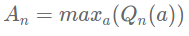

This means that we are only paying attention to the exploiting side of the problem, and exploring is not taking place. We could use a minute variable called epsilon for the method to explore a random action with that probability and exploit with the probability of (1 - eps), this is called eps-greedy. These two methods could efficiently be implemented with the same class:

In [26]:
#importing dependencies

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%config Completer.use_jedi = False

We define a class to represent the greedy method as an object with the following attributes:
- *k*: number of arms (int)
- *eps*: probability of random action (float)
- *iters*: number of steps (int)
- *rewards*: [default] is a set of random values normally distributed with mean = 0, could be set to a arbitrary array of size 'k'

In [36]:
class GreedyBandit:
    
    def __init__(self, k, eps, iters, rewards='random'):
        
        self.k = k
        self.eps = eps
        self.iters = iters
        
        #step count
        self.n = 0
        
        #step count for each arm
        self.k_n = np.zeros(k)
        
        #mean value
        self.mean = 0
        
        #reward history
        self.history = np.zeros(iters)
        
        #each arm reward history
        self.k_history = np.zeros(k)
        
        if type(rewards) == list or type(rewards).__module__ == np.__name__:
            #User-defined averages            
            self.rewards = np.array(rewards)
        elif rewards == 'random':
            #Draw means from probability distribution
            self.rewards = np.random.normal(0, 1, k)
        
    def generate(self):
        
        p = np.random.rand()
        if self.eps == 0 and self.n == 0:
            a = np.random.choice(self.k)
        elif p < self.eps:
            # Random action
            a = np.random.choice(self.k)
        else:
            # Greedy action
            a = np.argmax(self.k_history)
            
        reward = np.random.normal(self.rewards[a], 1)
        
        self.n += 1
        self.k_n[a] += 1
        
        self.mean +=  (reward - self.mean)/self.n
        
        self.k_history[a] += (reward - self.k_history[a])/self.k_n[a]
        
        
    def go(self):
        
        for i in range(self.iters):
            self.generate()
            self.history[i] = self.mean
    

We will compare results for the different amounts of epsilons, and assume that the bandit has 10 arms (k=10) and run 1000 steps for each epoch. 

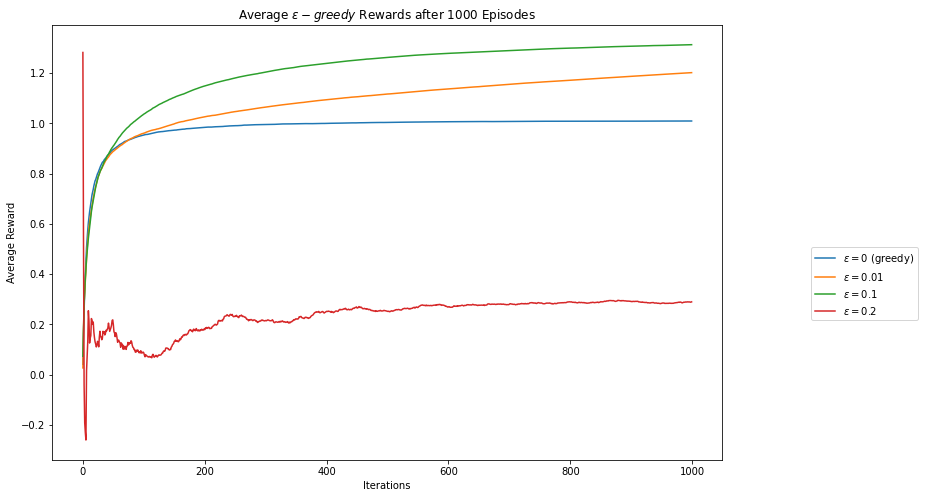

In [37]:
k = 10
iters = 1000

eps_0_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)
eps_2_rewards = np.zeros(iters)

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    eps_0 = GreedyBandit(k, 0, iters)
    eps_01 = GreedyBandit(k, 0.01, iters, eps_0.rewards.copy())
    eps_1 = GreedyBandit(k, 0.1, iters, eps_0.rewards.copy())
    eps_2 = GreedyBandit(k, 0.2, iters, eps_0.rewards.copy())
    
    # Run experiments
    eps_0.go()
    eps_01.go()
    eps_1.go()
    eps_2.go()
    
    # Update long-term averages
    eps_0_rewards = eps_0_rewards + (
        eps_0.history - eps_0_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (
        eps_01.history - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.history - eps_1_rewards) / (i + 1)
    eps_2_rewards = eps_2_rewards + (
        eps_1.history - eps_1_rewards) / (i + 1)
    
    
plt.figure(figsize=(12,8))
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_rewards, label="$\epsilon=0.01$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.plot(eps_2_rewards, label="$\epsilon=0.2$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes) 
    + " Episodes")
plt.show()